# How to work with Weather-Induced Extremes Digital Twin data on Earth Data Hub

***
This notebook will provide you guidance on how to access and use the `2024-03-08-i7yv-oper-sfc-v0.zarr` datset on Earth Data Hub. This is a sample dataset for the Weather-Induced Extremes Digital Twin.

Our first goal is to plot the forcasted 2 metre temperature over central Europe on March 08 2024, specifically the first six forcast steps after the reference forcast datetime 2024-03-08T00:00.

After that, we will plot a longer timeseries with all forecast steps for the city of Berlin.
***

## What you will learn:

* how to access and preview the dataset
* select and reduce the data
* plot the results

## Data access and preview
***

Xarray and Dask work together following a lazy principle. This means when you access and manipulate a Zarr store the data is in not immediately downloaded and loaded in memory. Instead, Dask constructs a task graph that represents the operations to be performed. A smart user will reduce the amount of data that needs to be downloaded before the computation takes place (e.g., when the `.compute()` or `.plot()` methods are called).

To preview the data, only the dataset metadata must be downloaded. Xarray does this automatically:

***

In [2]:
import xarray as xr

# your `~/.netrc` file MUST contain your credentials for earthdatahub.com
#
# machine earthdatahub.com
#   login {your_username}
#   password {your_password}

ds = xr.open_dataset(
    "https://earthdatahub.com/stores/destine-extreme-dt/2024-03-08-i7yv-oper-sfc-v0.zarr",
    engine="zarr",
    chunks={},
    storage_options={"client_kwargs": {"trust_env": "true"}},
)
ds

<xarray.Dataset> Size: 52GB
Dimensions:            (step: 96, latitude: 4097, longitude: 8192)
Coordinates:
    heightAboveGround  float64 8B ...
  * latitude           (latitude) float64 33kB 90.0 89.96 89.91 ... -89.95 -90.0
  * longitude          (longitude) float64 66kB 0.0 0.04395 ... 359.9 360.0
  * step               (step) timedelta64[ns] 768B 00:00:00 ... 3 days 23:00:00
    time               datetime64[ns] 8B ...
Data variables:
    d2m                (step, latitude, longitude) float32 13GB dask.array<chunksize=(24, 1024, 1024), meta=np.ndarray>
    t2m                (step, latitude, longitude) float32 13GB dask.array<chunksize=(24, 1024, 1024), meta=np.ndarray>
    u10                (step, latitude, longitude) float32 13GB dask.array<chunksize=(24, 1024, 1024), meta=np.ndarray>
    v10                (step, latitude, longitude) float32 13GB dask.array<chunksize=(24, 1024, 1024), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          0
    history:                 2024-03-16T13:32 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

## Working with data

Datasets on EDH are typically very large and remotely hosted. Typical use imply a selection of the data followed by one or more reduction steps to be performed in a local or distributed Dask environment. 

The structure of a workflow that uses EDH data looks like this:
1. data selection
2. (optional) data reduction
3. (optional) visualization

## 2 metre temperature over central Europe

### 1. Data selection

First, we select the 2 metre temperature variable from the Extremes DT sample dataset. Then, we perform a geographical selection corresponding to the central Europe area. This reduces the amount of data that will be downloaded from EDH. Finally we convert the temperature to `°C`.

In [3]:
t2m_central_europe = ds.t2m.sel(**{"latitude": slice(55, 45), "longitude": slice(2, 24)}) - 273.15
t2m_central_europe.attrs["units"] = "C"
t2m_central_europe

<xarray.DataArray 't2m' (step: 96, latitude: 228, longitude: 501)> Size: 44MB
dask.array<sub, shape=(96, 228, 501), dtype=float32, chunksize=(24, 227, 501), chunktype=numpy.ndarray>
Coordinates:
    heightAboveGround  float64 8B ...
  * latitude           (latitude) float64 2kB 54.98 54.93 54.89 ... 45.04 45.0
  * longitude          (longitude) float64 4kB 2.021 2.065 2.109 ... 23.95 23.99
  * step               (step) timedelta64[ns] 768B 00:00:00 ... 3 days 23:00:00
    time               datetime64[ns] 8B ...
Attributes:
    units:    C

At this point, no data has been downloaded yet, nor loaded in memory.

We can select the forecast steps.

In [13]:
t2m_central_europe_0_6 = t2m_central_europe.isel(step=slice(0,24))
t2m_central_europe_0_6

<xarray.DataArray 't2m' (step: 24, latitude: 228, longitude: 501)> Size: 11MB
dask.array<getitem, shape=(24, 228, 501), dtype=float32, chunksize=(24, 227, 501), chunktype=numpy.ndarray>
Coordinates:
    heightAboveGround  float64 8B ...
  * latitude           (latitude) float64 2kB 54.98 54.93 54.89 ... 45.04 45.0
  * longitude          (longitude) float64 4kB 2.021 2.065 2.109 ... 23.95 23.99
  * step               (step) timedelta64[ns] 192B 00:00:00 ... 23:00:00
    time               datetime64[ns] 8B ...
Attributes:
    units:    C

Now the selection is small enough to call `.compute()` on it. This will trigger the download of the data from EDH and load it in memory. 

We can measure the time it takes:

In [14]:
%%time

t2m_central_europe_0_6.compute();

CPU times: user 366 ms, sys: 152 ms, total: 518 ms
Wall time: 690 ms


The selection was small, this didn't tale long!

### 3. Visualization

We can finally plot the selected forecast steps on a series of maps

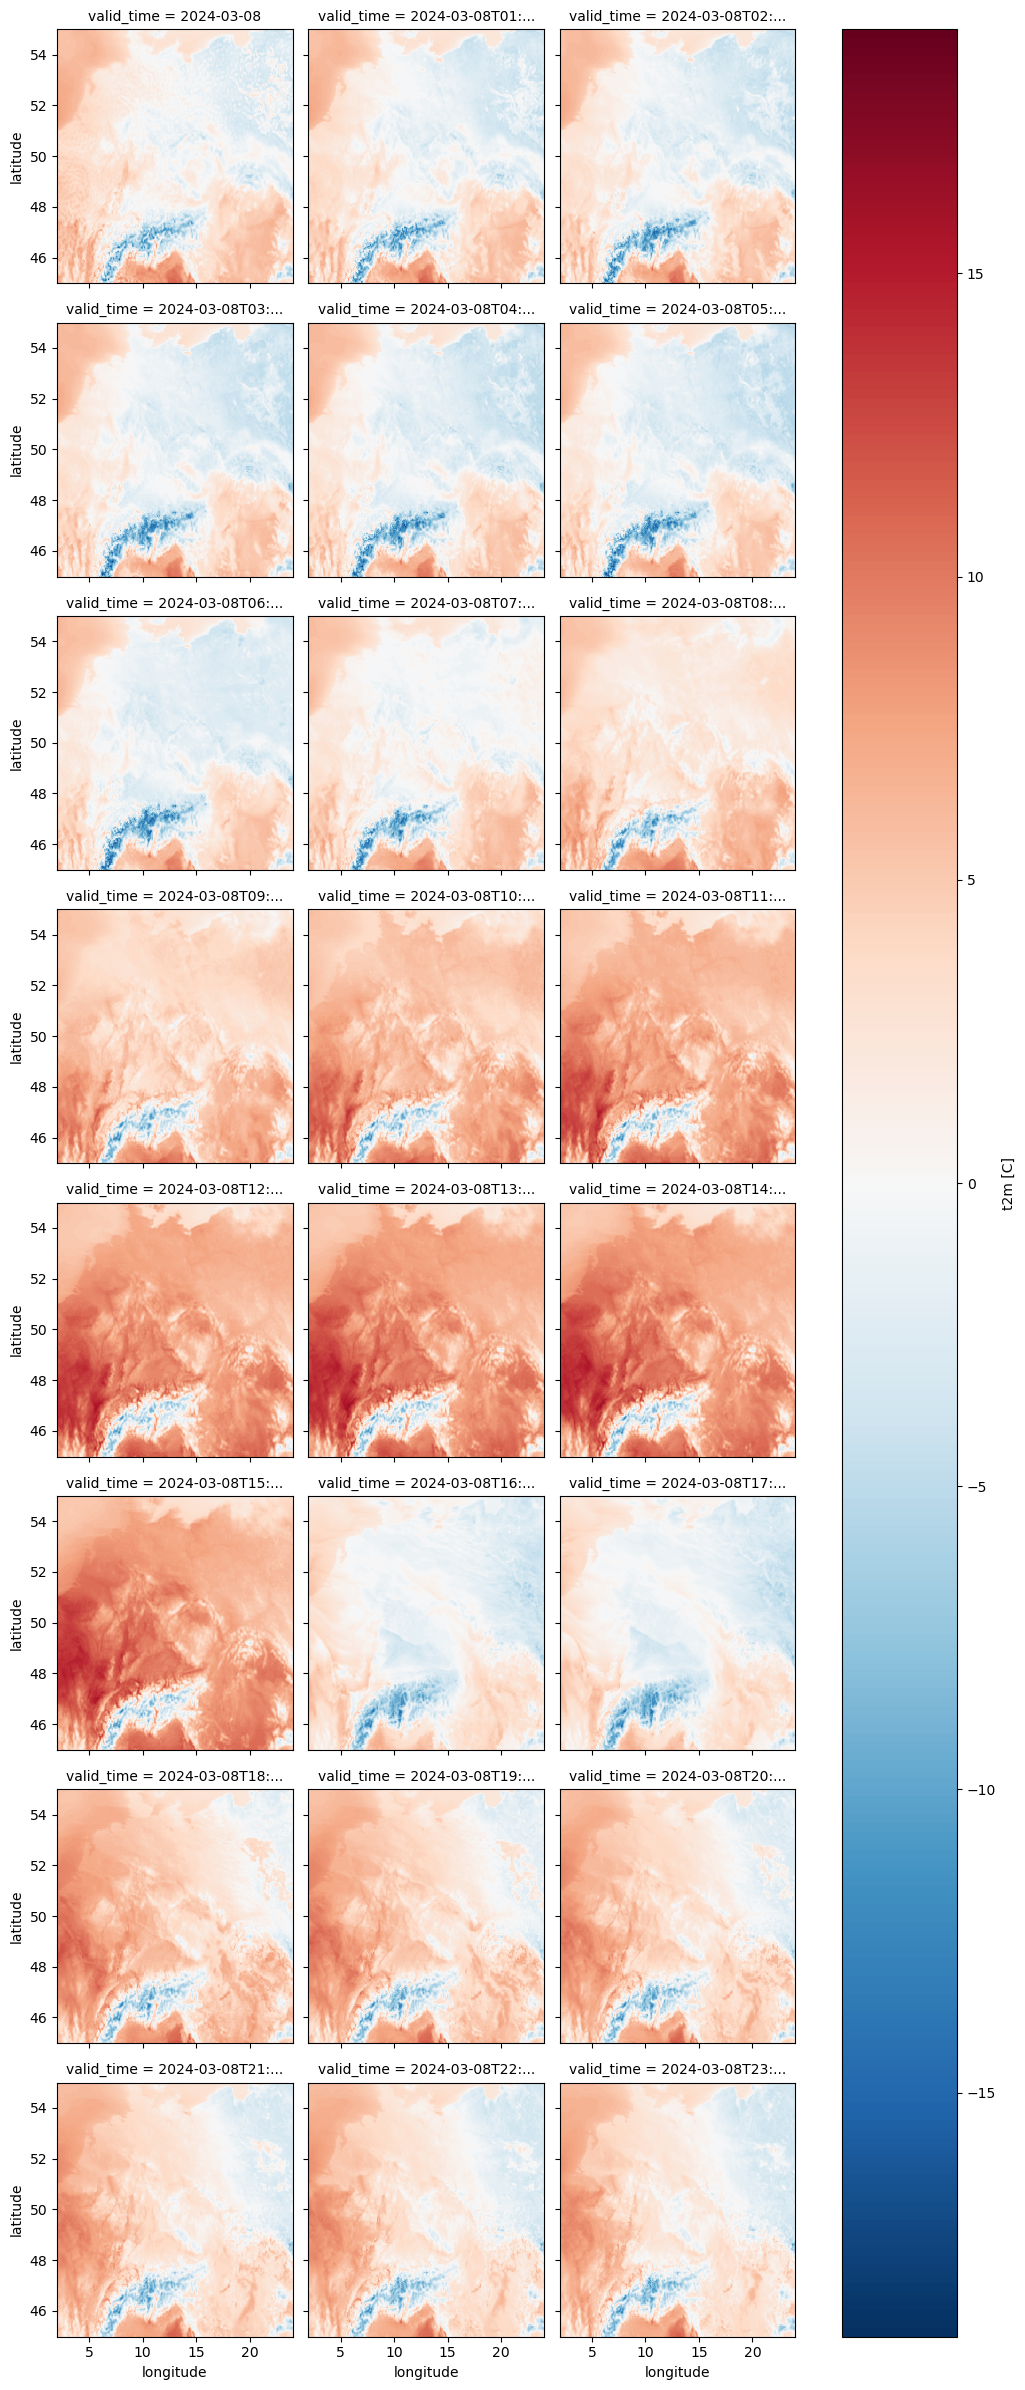

In [15]:
valid_times = t2m_central_europe_0_6.step.values + t2m_central_europe_0_6.time.values
t2m_central_europe_0_6.assign_coords(step=valid_times).rename({"step":"valid_time"}).plot(x="longitude", y="latitude", col="valid_time", col_wrap=3)

## 2 metre temperature over Berlin, long timeseries

We want to plot a longer timeseries for the forcasted 2 metre temperature over Berlin. We select the nearest values to Berlin and convert them to `°C`.

In [10]:
t2m_Berlin = ds.t2m.sel(**{"latitude": 52.5, "longitude": 13.4}, method="nearest") - 273.15
t2m_Berlin.attrs["units"] = "C"
t2m_Berlin

<xarray.DataArray 't2m' (step: 96)> Size: 384B
dask.array<sub, shape=(96,), dtype=float32, chunksize=(24,), chunktype=numpy.ndarray>
Coordinates:
    heightAboveGround  float64 8B ...
    latitude           float64 8B 52.51
    longitude          float64 8B 13.4
  * step               (step) timedelta64[ns] 768B 00:00:00 ... 3 days 23:00:00
    time               datetime64[ns] 8B ...
Attributes:
    units:    C

This is already small enought to be computed:

In [11]:
%%time

t2m_Berlin.compute();

CPU times: user 475 ms, sys: 337 ms, total: 812 ms
Wall time: 429 ms


Now that the data is loaded in memory we can easily plot the entire timeseries up to forecast step 95

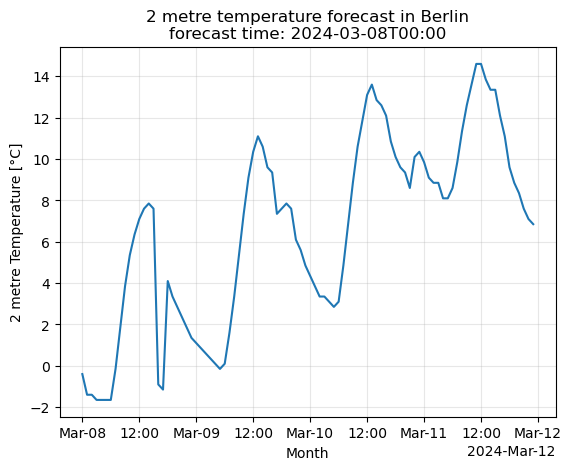

In [12]:
import matplotlib.pyplot as plt

valid_times = t2m_Berlin.step.values + t2m_Berlin.time.values
t2m_Berlin.assign_coords(step=valid_times).rename({"step":"valid_time"}).plot()
plt.title("2 metre temperature forecast in Berlin\nforecast time: 2024-03-08T00:00")
plt.xlabel("Month")
plt.ylabel("2 metre Temperature [°C]")
plt.grid(alpha=0.3)
plt.show()